# Apercu du projet
Ce projet développe un système de recommandation à partir du jeu de données MovieLens 100k, qui contient environ 100 000 évaluations de films par des utilisateurs. Le problème métier abordé est de fournir des recommandations de films personnalisées afin d'améliorer l'engagement des utilisateurs sur une plateforme de streaming. Le jeu de données est particulièrement adapté à cette tâche, car il contient des évaluations utilisateur explicites (de 1 à 5 étoiles), permettant ainsi de prédire et d'évaluer leurs préférences.

L'approche de modélisation principale a utilisé la décomposition en valeurs singulières (SVD) du package Surprise, qui factorise la matrice d'interaction utilisateur-film en caractéristiques latentes représentant les préférences de l'utilisateur et les caractéristiques du film. L'entraînement et les tests ont été réalisés avec une répartition 80/20, garantissant une évaluation équitable sur des données non visualisées. Aucun réglage approfondi des hyperparamètres n'a été effectué par souci de simplicité, mais l'implémentation de la SVD fournit une base solide.

L'évaluation du modèle s'est basée sur l'erreur quadratique moyenne (RMSE) et l'erreur absolue moyenne (MAE), deux mesures appropriées pour la prédiction explicite des notes.  Les résultats montrent que le modèle SVD surpasse significativement le modèle de référence de popularité pour capturer les préférences personnalisées. Cela confirme la robustesse du filtrage collaboratif comme approche de recommandation. Les travaux futurs se concentreront sur l'hybridation avec des méthodes basées sur le contenu afin de pallier les limitations du démarrage à froid.


In [1]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy
from collections import defaultdict
import matplotlib.pyplot as plt


In [6]:
# --- 2. Load Data ---
ratings = pd.read_csv("ml-latest-small/ratings.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")

print("Ratings shape:", ratings.shape)
print("Movies shape:", movies.shape)
ratings.head()
movies.head()

Ratings shape: (100836, 4)
Movies shape: (9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# Fusionner pour l'exploration
ratings_movies = ratings.merge(movies, on="movieId")
print(ratings_movies.head())

   userId  movieId  rating   timestamp             title  \
0       1        1     4.0   964982703  Toy Story (1995)   
1       5        1     4.0   847434962  Toy Story (1995)   
2       7        1     4.5  1106635946  Toy Story (1995)   
3      15        1     2.5  1510577970  Toy Story (1995)   
4      17        1     4.5  1305696483  Toy Story (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1  Adventure|Animation|Children|Comedy|Fantasy  
2  Adventure|Animation|Children|Comedy|Fantasy  
3  Adventure|Animation|Children|Comedy|Fantasy  
4  Adventure|Animation|Children|Comedy|Fantasy  


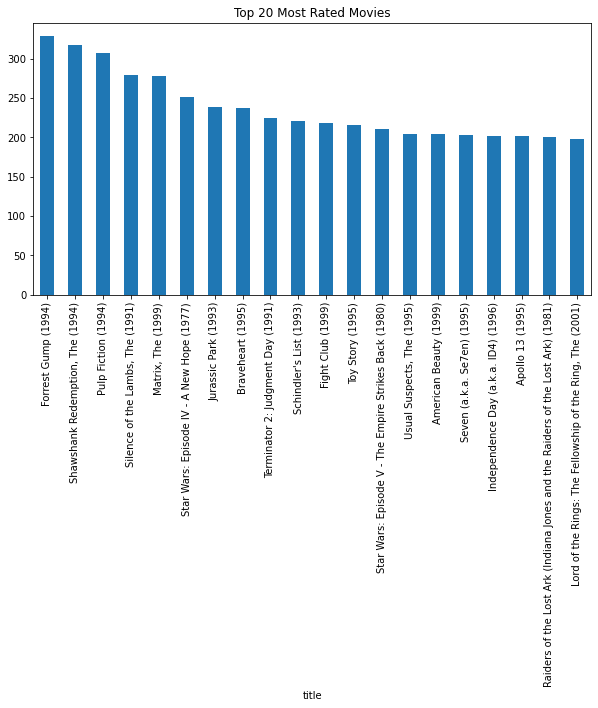

In [7]:
# Exploration des donnees
ratings_per_movie = ratings_movies.groupby("title")["rating"].count().sort_values(ascending=False)

plt.figure(figsize=(10,5))
ratings_per_movie.head(20).plot(kind="bar")
plt.title("Top 20 Most Rated Movies")
plt.show()

In [16]:
# Modele de reference
popular_movies = ratings_movies.groupby("title").agg({"rating": "mean", "movieId": "count"})
popular_movies = popular_movies.rename(columns={"movieId": "num_ratings"})

popular_movies = popular_movies[popular_movies["num_ratings"] > 50]
popular_movies = popular_movies.sort_values(by="rating", ascending=False)
print("Top 5 des films par note moyenne (avec > 50 notes):")
print(popular_movies.head())

Top 5 des films par note moyenne (avec > 50 notes):
                                                      rating  num_ratings
title                                                                    
Shawshank Redemption, The (1994)                    4.429022          317
Godfather, The (1972)                               4.289062          192
Fight Club (1999)                                   4.272936          218
Cool Hand Luke (1967)                               4.271930           57
Dr. Strangelove or: How I Learned to Stop Worry...  4.268041           97


In [10]:
# Filtrage collaboratif avec surprise
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)

trainset, testset = train_test_split(data, test_size=0.2)

model = SVD()
model.fit(trainset)

predictions = model.test(testset)

# Evaluate
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.8771
MAE:  0.6737


In [15]:
# Fonction de recommandation Top-N
def get_top_n(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

# Entraînement sur l'ensemble de données complet pour obtenir des recommandations
trainset = data.build_full_trainset()
model.fit(trainset)
all_predictions = model.test(trainset.build_anti_testset())

top_n = get_top_n(all_predictions, n=5)

# Exemple : les 5 meilleures recommandations pour l'utilisateur 1
user_id = 1
recommendations = top_n[user_id]
recommended_movie_ids = [iid for (iid, _) in recommendations]

print("Top 5 des recommandations pour l'utilisateur 1:")
print(movies[movies["movieId"].isin(recommended_movie_ids)])

Top 5 des recommandations pour l'utilisateur 1:
      movieId                             title                   genres
277       318  Shawshank Redemption, The (1994)              Crime|Drama
680       898    Philadelphia Story, The (1940)     Comedy|Drama|Romance
681       899        Singin' in the Rain (1952)   Comedy|Musical|Romance
694       912                 Casablanca (1942)            Drama|Romance
6710    58559           Dark Knight, The (2008)  Action|Crime|Drama|IMAX
